# **Whales identification Convolutional Neural Network Architecture**

**Whales identification Convolutional Neural Networks Architecture**


By applying convolutional neural networks (CNNs) to analyse images of humpback whale tail flukes and infer the identity of the individual whale represents the fundamental solution for this project. The following are the main phases that are possibly required to construct such a system:


1.   **Use a large dataset** of photographs of humpback whale tail flukes. To assure the model's generalizability, the dataset should include images captured from a variety of angles and illumination conditions.
2.   **Data Preprocessing:** To increase the size of the dataset, preprocess the images by resizing them to a standard size, normalising the pixel values, and employing data augmentation techniques such as rotation and inverting.
3.   **Model Architecture:** Build a CNN model architecture that's appropriate for the recognition of humpback whale tail flukes. The predictive framework must include convolutional layers that retrieve image features, pooling layers to reduce spatial dimensions, and fully connected layers to make predicted outcomes. 
4.  **Training:** Train the model via a suitable optimizer and loss function on the data set that has been preprocessed. Improve the training process by monitoring its progress with metrics, and by employing techniques such as early stopping and learning rate scheduling.

5.   **Evaluate the model's performance** on the testing images that have not been utilised during training. Apply metrics such as accuracy, precision, and recall to evaluate the performance.

Therefore we test the CNN with different settings and estimate the results of classification of training set.   

**Clone the Google Drive**

In order to make it simpler to access and work with files saved in Google Drive inside a Colab notebook, cloning a Google Drive in Colab is helpful. A local copy of the files on the Colab runtime is created by cloning the disc and may be accessed and used in the same ways as any other local file system.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Necessary Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import csv
import cv2
import random
import warnings
from os.path import split
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [ ]:
warnings.filterwarnings("ignore", message="`sparse` was renamed to `sparse_output`")

Load the dataset

In [ ]:
training_Data = pd.read_csv("/content/drive/MyDrive/whale-categorization-playground.zip (Unzipped Files)/train.csv")
training_Data.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


Count Total Number of Training and Testing Images

In [ ]:
training_Dir = "/content/drive/MyDrive/whale-categorization-playground.zip (Unzipped Files)/train/"
testing_Dir="/content/drive/MyDrive/whale-categorization-playground.zip (Unzipped Files)/test"


In [ ]:
print("Total images in the train Directory: ",{len(os.listdir(training_Dir))})
print("Totalimages in the test Directory: ",{len(os.listdir(testing_Dir))})

Total images in the train Directory:  {9851}
Totalimages in the test Directory:  {15613}


In [ ]:
whale_count = training_Data.groupby('Id').size()
print("Occurences of different whales:")
print(whale_count)
print(f"Total number of Whales: {len(whale_count)}")


Occurences of different whales:
Id
new_whale    810
w_0013924      3
w_001ebbc      1
w_002222a      2
w_002b682      1
            ... 
w_ffb4e3d      2
w_ffbd74c      2
w_ffcd98e      2
w_ffda8b2      4
w_ffdab7a      1
Length: 4251, dtype: int64
Total number of Whales: 4251


# Image Preprocessing

Converts an RGB image to grayscale using the luminosity method


This cell computes the mean of the three color channels (R,G,B), resulting in a single-channel uniform image. The output grayscale values will range from 0 to 255.

In [ ]:
def convert_rgb_to_gray(rgb_image):
    """
    rgb_image (ndarray): shape (height, width, 3) 
    
    Returns:
    gray_image: shape (height, width) 
    """
    if len(rgb_image.shape) == 3:
        gray_image = np.mean(rgb_image, axis=2)
    else:
        gray_image = rgb_image
    return gray_image

Resizes an image to 64x64 pixels, returns to normal its pixel values to the interval [0, 1], and adds a grayscale channel.


In [ ]:
def preprocess_image(image):
    """
    Returns:
    ndarray: A numpy array of shape (64, 64, 1) representing the preprocessed image.
    """
    resized_image = cv2.resize(image, (64, 64), cv2.INTER_NEAREST)
    threshold = cv2.NORM_MINMAX
    # 0.0 is the minmum value
    # 1.0 is the maximum value
    normalized_image = cv2.normalize(resized_image, None, 0.0, 1.0, threshold)
    gray_image = convert_rgb_to_gray(normalized_image)
    preprocessed_image = np.expand_dims(gray_image, axis=-1)
    return preprocessed_image

In [ ]:
def transform_image(dataset):
    dataset_directory = {"train": training_Dir, "test": testing_Dir}
    try:
        file_directory = dataset_directory[dataset]
    except KeyError:
        raise ValueError("Invalid dataset name, must be either 'train' or 'test'")

    file_list = os.listdir(file_directory)
    #Count the number of files in current directory
    dataset_shape = (len(file_list), 64, 64, 1)
    X_dataset = np.zeros(dataset_shape)
    
    i = 0
    while i < len(file_list):
        img = mpimg.imread(file_directory + "/" + file_list[i])
        gs_img = convert_rgb_to_gray(img)
        trans_img = preprocess_image(gs_img)
        X_dataset[i] = trans_img
        i += 1
        
    return X_dataset

Some training samples  are selected at random and shown from the training folder

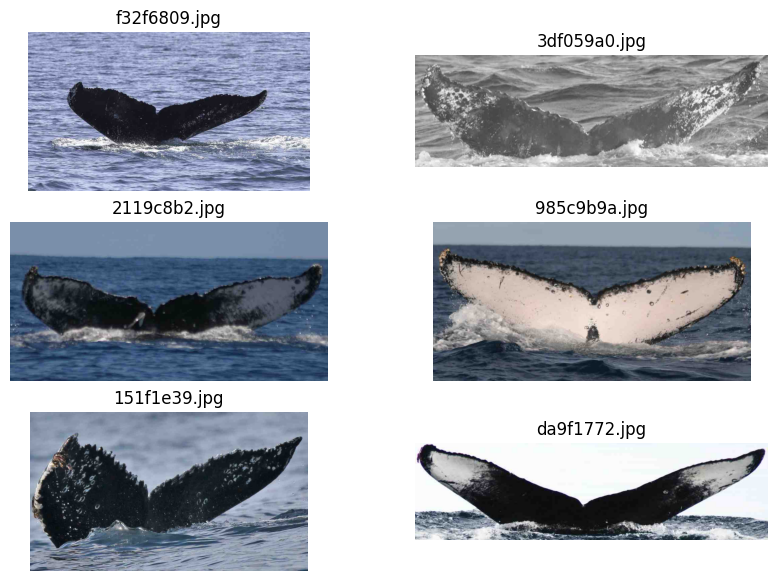

In [ ]:
def show_sample_images():
    file_list = os.listdir(training_Dir)
    sample_files = random.sample(file_list, 6)
    
    figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,7))
    for i, file_name in enumerate(sample_files):
        show_image = mpimg.imread(training_Dir + "/" + file_name)
        axes[i//2][i%2].imshow(show_image)
        axes[i//2][i%2].set_title(file_name)
        axes[i//2][i%2].axis('off')
    
    plt.show()

show_sample_images()

#Encode Labels using OneHotEncoder

This code encodes the labels and converts them to numerical values by utilising the LabelEncoder method from the scikit-learn library. The fit_transform method of the LabelEncoder class is used to adapt the encoder to the labels and convert the labels to encoded numeric values. Using the np.array function, encoded labels are converted to a numpy array.

In [ ]:
def prepare_labels(Y):

    labels_encoder = LabelEncoder()
    integer_encoded = labels_encoder.fit_transform(Y)
    print("Integer Encoded:\n",integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print("One Hot Encoded:\n",onehot_encoded)
    return onehot_encoded, labels_encoder

Now we prepare the data to be used for training.

In [ ]:
X_dataset = transform_image("train")
print("Shape of train data: ", X_dataset.shape)
y, encoded_labels = prepare_labels(array(training_Data['Id']))

Shape of train data:  (9851, 64, 64, 1)
Integer Encoded:
 [3741  310 3613 ... 2337  746 3088]
One Hot Encoded:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Convolutional Neural Network model and results

Import Libraries related to CNN

In [ ]:
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential

In [ ]:
#identify unique labels in dataset
unique_labels = np.unique(training_Data['Id'])
print("Unique Labels presented in dataset:\n",unique_labels)

Unique Labels presented in dataset:
 ['new_whale' 'w_0013924' 'w_001ebbc' ... 'w_ffcd98e' 'w_ffda8b2'
 'w_ffdab7a']


In [ ]:
#shape of input image
input_shape = (64, 64, 1)

In [ ]:
output_dimensions= len(unique_labels)
print("Output Dimensions: ", output_dimensions)

Output Dimensions:  4251


#This architecture consists of the following layers:

Convolutional layer with 32 filters, kernel (3, 3), and a stride of (1, 1)

BatchNormalization layer

ReLU activation layer

MaxPooling2D layer with (3, 3) kernel size

Convolutional layer with 64 filters, (3, 3) kernel size, and a stride of (1, 1)

ReLU activation layer

BatchNormalization layer

AveragePooling2D layer with a filter size of (3, 3)

Flatten layer - A 1D vector

Dense layer with 512 units and a ReLU activation function

Dropout layer with a rate of 0.5

Dense layer with output dimensions units and a softmax activation function.

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), strides=(1, 1), input_shape=input_shape),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((3, 3)),
    Conv2D(64, (3, 3), strides=(1, 1)),
    Activation('relu'),
    BatchNormalization(axis=3),
    AveragePooling2D((3, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(output_dimensions, activation='softmax')

])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 activation_3 (Activation)   (None, 18, 18, 64)       

The total number of parameters that can potentially be trained in the network is 3,380,123. All of the network's layer biases as well as weights are included in this.

**Plot of Our Convolutional Neural Network Architecture**

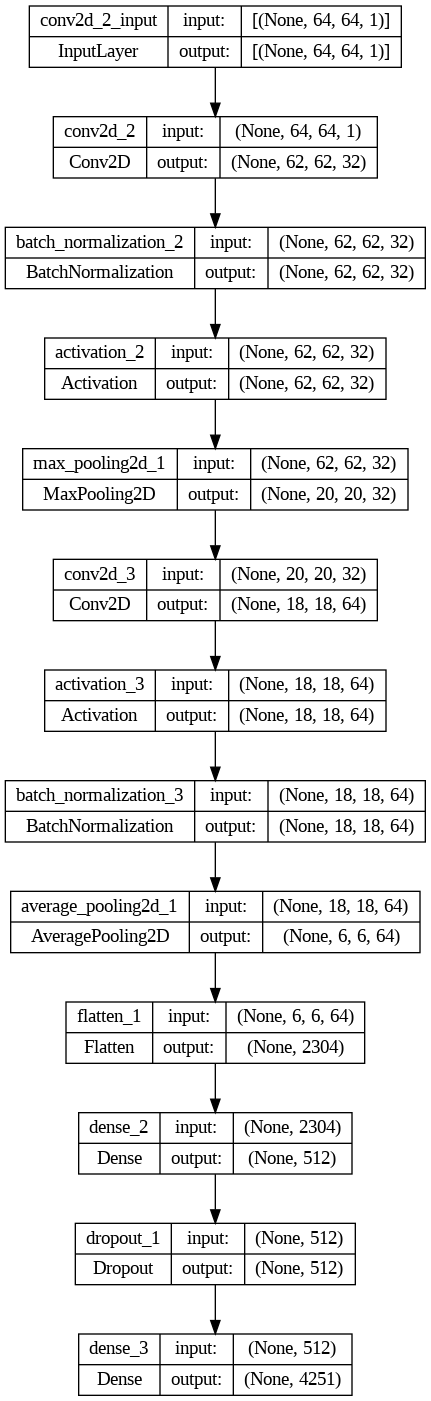

In [ ]:
from tensorflow.keras.utils import plot_model
save_architecture= "cnn_plot.png"
plot_model(cnn_model, to_file=save_architecture, show_shapes=True)

Compile the Model Before Training

In [ ]:
cnn_model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

Computing class weights with corresponding sklearn function: 

In [ ]:
initial_weights=cnn_model.get_weights()
X = X_dataset[1:]
model_hist = cnn_model.fit(X, 
                    y, 
                    epochs=200, 
                    batch_size=100, 
                    verbose=1)

Epoch 1/200
99/99 [==============================] - 13s 15ms/step - loss: 8.0551 - accuracy: 0.0793
Epoch 2/200
99/99 [==============================] - 1s 13ms/step - loss: 7.5879 - accuracy: 0.0822
Epoch 3/200
99/99 [==============================] - 1s 14ms/step - loss: 7.1334 - accuracy: 0.0822
Epoch 4/200
99/99 [==============================] - 1s 14ms/step - loss: 6.5380 - accuracy: 0.0842
Epoch 5/200
99/99 [==============================] - 1s 14ms/step - loss: 5.6707 - accuracy: 0.1026
Epoch 6/200
99/99 [==============================] - 1s 13ms/step - loss: 4.5292 - accuracy: 0.1740
Epoch 7/200
99/99 [==============================] - 1s 13ms/step - loss: 3.4421 - accuracy: 0.3079
Epoch 8/200
99/99 [==============================] - 1s 13ms/step - loss: 2.6233 - accuracy: 0.4382
Epoch 9/200
99/99 [==============================] - 1s 13ms/step - loss: 2.0847 - accuracy: 0.5357
Epoch 10/200
99/99 [==============================] - 1s 13ms/step - loss: 1.6611 - accuracy: 0.614

Our CNN model has been trained on a dataset and can now predict the labels of its training data with a 90% of accuracy. This demonstrates that the model is capable of learning patterns and features from the training data that enable it to differentiate between classes. During training, it is intended to keep an eye on the validation loss and halt when it begins to rise or when performance stands still after a certain number of epochs.

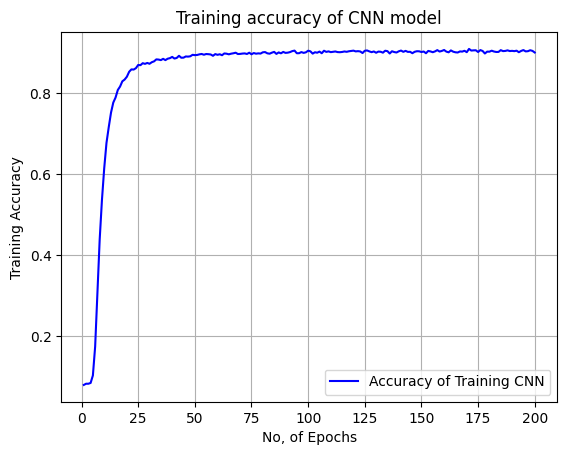

In [ ]:
complete_hist = model_hist.history
acc_values = complete_hist['accuracy']
no_of_epoch = range(1, len(acc_values) + 1)

plt.plot(no_of_epoch, acc_values, 'b-', label='Accuracy of Training CNN')
plt.rcParams["figure.figsize"] = (8,8)
plt.title('Training accuracy of CNN model')
plt.xlabel('No, of Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

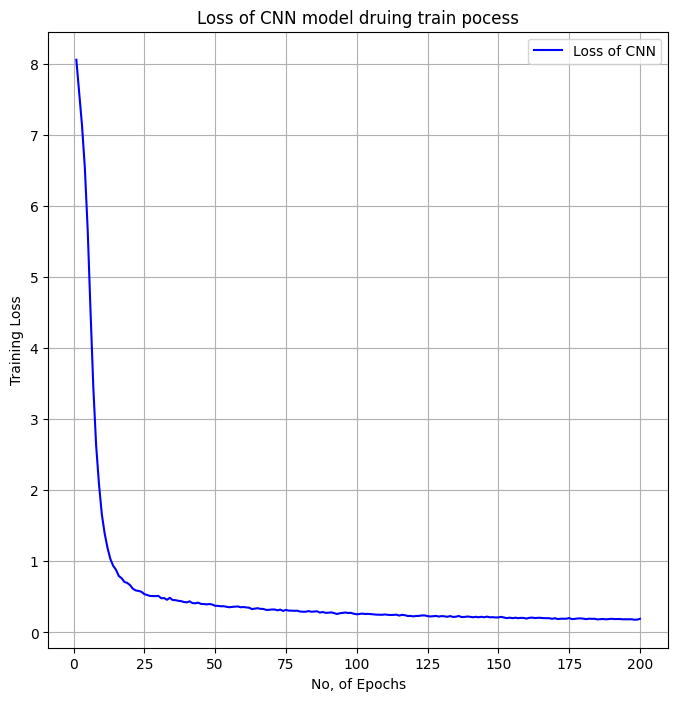

In [ ]:
loss_record = complete_hist['loss']
epoch_number_ = range(1, len(loss_record) + 1)

plt.plot(epoch_number_, loss_record, 'b-', label='Loss of CNN')
plt.title('Loss of CNN model druing train pocess')
plt.xlabel('No, of Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Data Augmentation

To increase the training samples and avoid overfitting, deep learning models often make use of data augmentation, especially for image recognition tasks. In order to apply multiple data augmentation methods to pictures during training, the well-known deep learning package Keras has an integrated data augmentation module called ImageDataGenerator.

In [ ]:
#Simplest Augmentation Method
data_augmentation = image.ImageDataGenerator() 
data_augmentation.fit(X)

In [ ]:
cnn_model.set_weights(initial_weights)
history_after_augmentation=cnn_model.fit(data_augmentation.flow(X, y, batch_size=100), epochs=200, verbose=1)
model_weights=cnn_model.get_weights()

Epoch 1/200
99/99 [==============================] - 2s 15ms/step - loss: 7.7953 - accuracy: 0.0775
Epoch 2/200
99/99 [==============================] - 1s 14ms/step - loss: 7.1254 - accuracy: 0.0818
Epoch 3/200
99/99 [==============================] - 2s 19ms/step - loss: 6.5144 - accuracy: 0.0834
Epoch 4/200
99/99 [==============================] - 3s 25ms/step - loss: 5.8083 - accuracy: 0.0947
Epoch 5/200
99/99 [==============================] - 1s 14ms/step - loss: 4.9992 - accuracy: 0.1332
Epoch 6/200
99/99 [==============================] - 1s 14ms/step - loss: 4.1376 - accuracy: 0.1991
Epoch 7/200
99/99 [==============================] - 1s 13ms/step - loss: 3.2812 - accuracy: 0.2846
Epoch 8/200
99/99 [==============================] - 1s 14ms/step - loss: 2.5273 - accuracy: 0.4014
Epoch 9/200
99/99 [==============================] - 1s 14ms/step - loss: 1.9473 - accuracy: 0.5110
Epoch 10/200
99/99 [==============================] - 1s 15ms/step - loss: 1.5413 - accuracy: 0.5947

<ipython-input-35-74c3f003cdf0>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy_values, 'b-', label='Training accuracy', color='r')


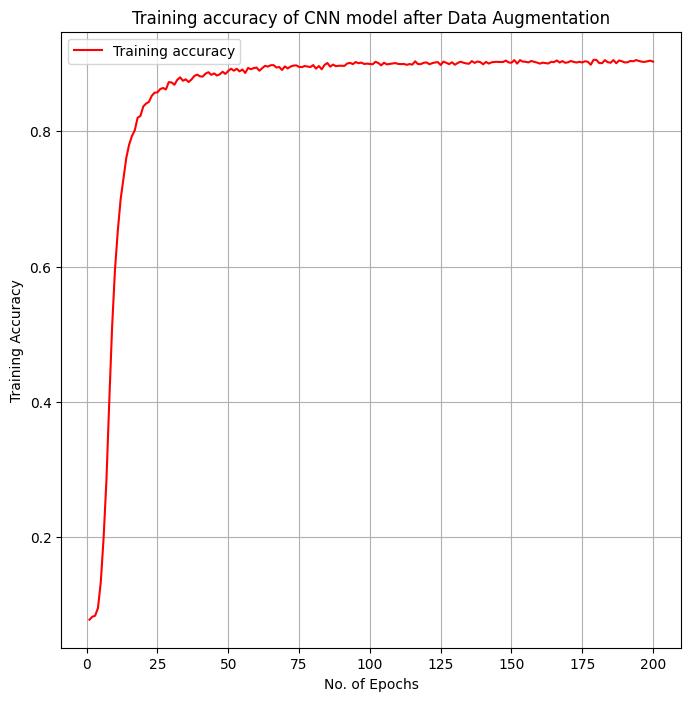

In [ ]:
history_dict_aug = history_after_augmentation.history
accuracy_values = history_dict_aug['accuracy']
epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'b-', label='Training accuracy', color='r')
plt.title('Training accuracy of CNN model after Data Augmentation')
plt.xlabel('No. of Epochs')
plt.ylabel('Training Accuracy')
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.grid(True)
plt.show()

We can see that introduction of augmentation (horizontal flips) slightly affected precision on training set, 90% accuracy was achieved. The Data Augmentaion is very effecient approach when you have very limited size of dataset and will highly affect the accuracy of model.

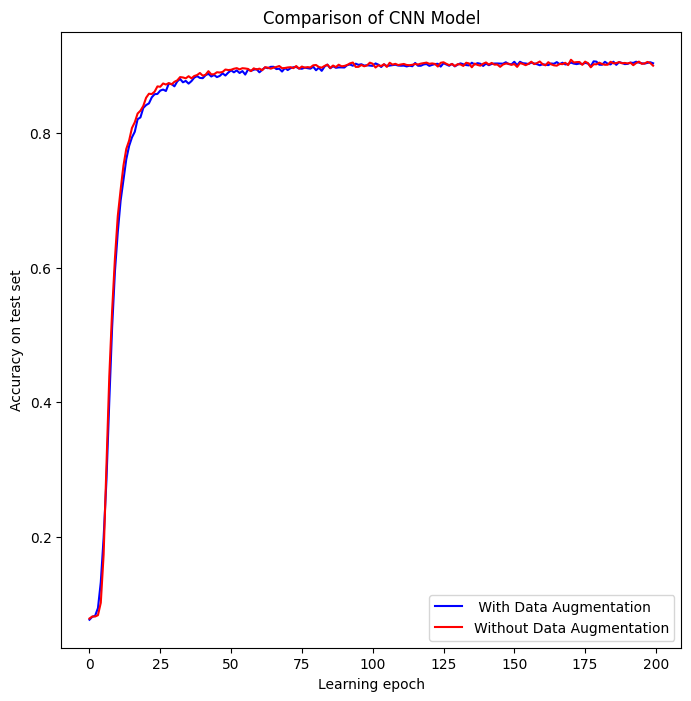

In [ ]:
plt.plot(history_after_augmentation.history['accuracy'], 'b-', label=" With Data Augmentation")
plt.plot(model_hist.history['accuracy'], label="Without Data Augmentation", color='r')
plt.rcParams["figure.figsize"] = (8,12)
plt.legend()
plt.title('Comparison of CNN Model')
plt.ylabel('Accuracy on test set')
plt.xlabel('Learning epoch')
plt.show()

# Submission of results

Preparing test images: 

In [ ]:
X_test = transform_image("test")
print("Shape of testing data: ", X_test.shape)

Shape of testing data:  (15613, 64, 64, 1)


After checking the shape of testing data, we are going to write the model's predicted results in the csv file.

In [ ]:
file_directory = os.listdir(testing_Dir) 
cnn_model.set_weights(model_weights)

predictions = []
i = 0
while i < len(file_directory):
    filename = file_directory[i]
    path = os.path.join(testing_Dir, filename)
    gray_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    resize_image = (cv2.resize(gray_image, (64, 64)))/255.0
    X_test = resize_image.reshape(-1, 64, 64, 1)
    y_prediction = cnn_model.predict(X_test)
    image_id = np.argsort(y_prediction[0])[::-1][:5]
    image_labels = encoded_labels.inverse_transform(image_id)
    predicted_labels = " ".join(image_labels)
    image = filename.split("/")[-1]
    predictions.append((image, predicted_labels))
    i += 1


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 36ms/step


In [ ]:
df = pd.DataFrame(predictions, columns=["Image", "Id"])
df.to_csv("test_sample_submission.csv", index=False)

1/1 [==============================] - 0s 54ms/step
Label of Testing image: new_whale w_861cc1c w_4fd48e7 w_8c66a16 w_7e1eb95


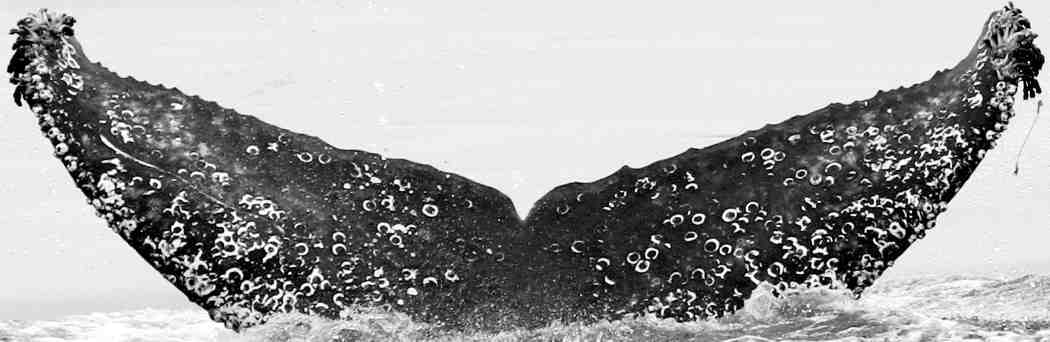



1/1 [==============================] - 0s 62ms/step
Label of Testing image: new_whale w_86b3de4 w_4ebeafb w_3745f59 w_31b020c


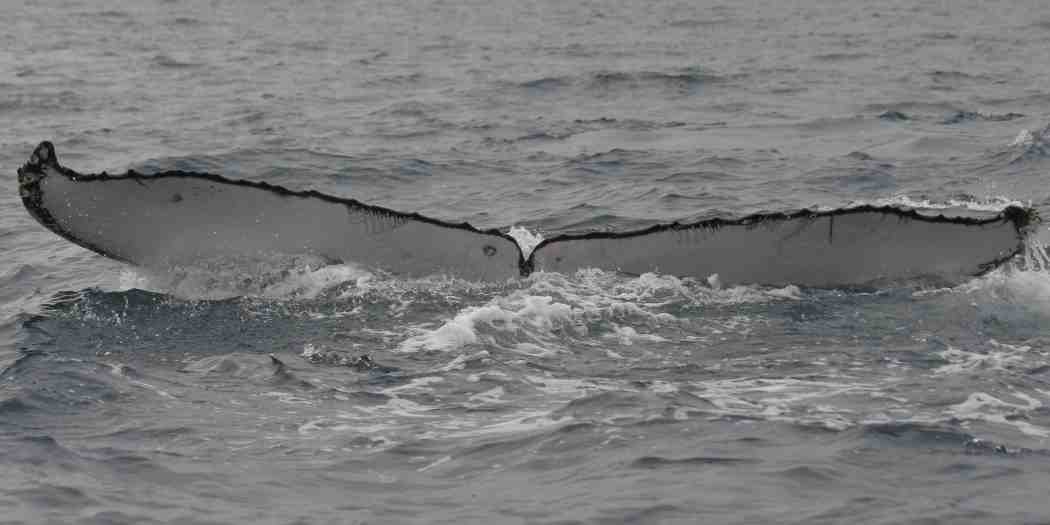



1/1 [==============================] - 0s 39ms/step
Label of Testing image: new_whale w_2870b33 w_0d0bc48 w_e02fe7b w_9ceb05d


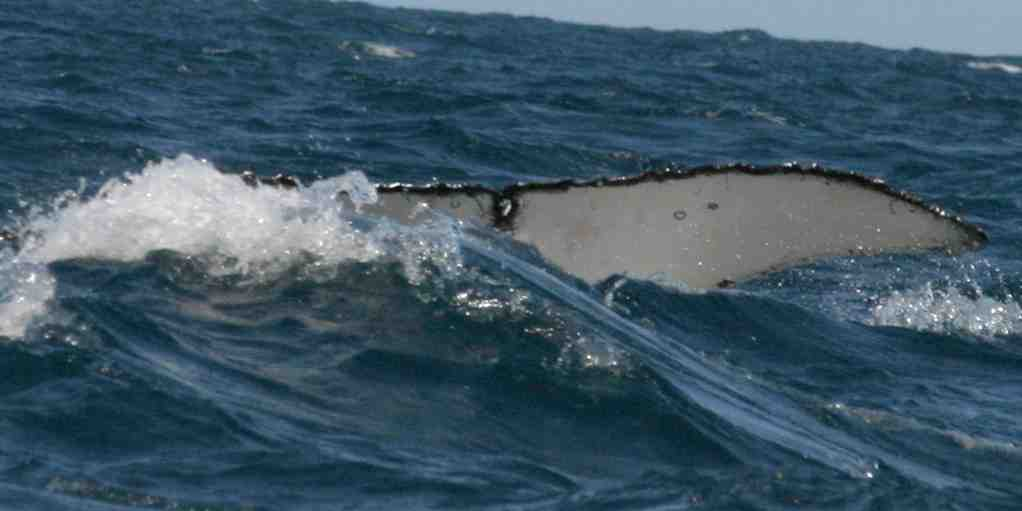



1/1 [==============================] - 0s 47ms/step
Label of Testing image: w_7e48479 new_whale w_7554f44 w_1dc6d62 w_98baff9


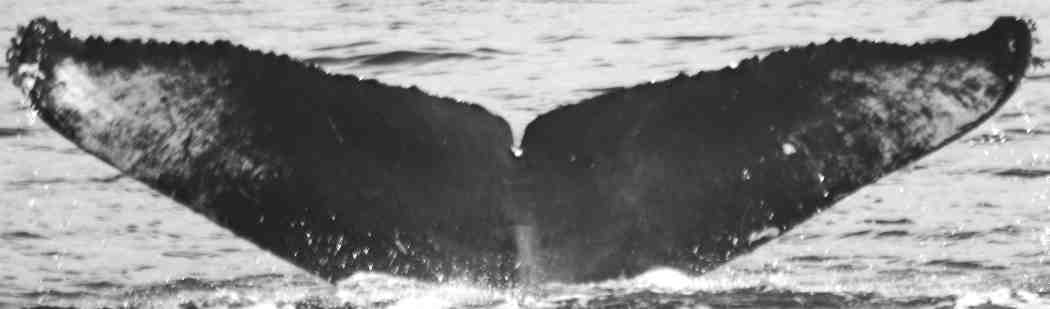

In [ ]:
from google.colab.patches import cv2_imshow
# Make predictions on the first 4 images and print the images with labels
for filename in file_directory[:4]:
    path = os.path.join(testing_Dir, filename)
    gray_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    resize_image = (cv2.resize(gray_image, (64, 64)))/255.0
    X_test = resize_image.reshape(-1, 64, 64, 1)
    y_prediction = cnn_model.predict(X_test)
    image_id = np.argsort(y_prediction[0])[::-1][:5]
    image_labels = encoded_labels.inverse_transform(image_id)
    predicted_labels = " ".join(image_labels)
    image = cv2.imread(path)
    print("Label of Testing image:",predicted_labels)
    cv2_imshow( image)
    print("\n")
    cv2.waitKey(0)